# Heat solver basic usage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td

## Temperature dependent properties

To handle functions of temperature several helper classes are introduced `TemperatureDependenceType = Union[TemperatureDependenceConstant, TemperatureDependenceLinear, TemperatureDependenceTable]`. There are derivatives of abstract `TemperatureDependence`.

In [2]:
constant = td.TemperatureDependenceConstant(value=2)
linear = td.TemperatureDependenceLinear(ref_temp=300, coeff=0.01)
table = td.TemperatureDependenceTable(temp_points=[250,300,350], func_values=[4,2,5])

These classes have basic vizualization functionalities.

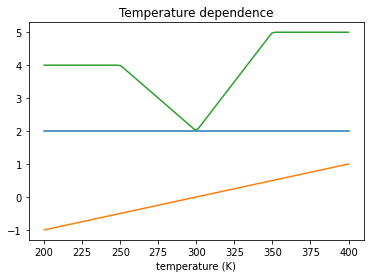

In [3]:
fig, ax = plt.subplots(1,1)
temp_plot_values = np.linspace(200,400,100)
constant.plot(temperature=temp_plot_values, ax=ax)
linear.plot(temperature=temp_plot_values, ax=ax)
table.plot(temperature=temp_plot_values, ax=ax)
plt.show()

## Material heat specification

Material classes now have an additional field `heat_spec: HeatSpecType`, which specifies heat properties of the material. It can be of two kinds `HeatSpecType = Union[HeatSpecSolid, HeatSpecFluid]`. `HeatSpecFluid` simply means that a given material is not part of heat simulation. But later on we might add some parameters to it.

In [4]:
heat_spec_fluid = td.HeatSpecFluid()

`HeatSpecSolid` contains both: parameters needed for heat simulation (density, capacity, heat conductivity) and effects of heat on optical properties (perturbations in permittivity and EM conductivity). For now we assume heat parameters to be constants, but perturbations in optical properties are temperature dependent and can be specified by the helper class from the previous section. For example:

In [5]:
permittivity_change = td.TemperatureDependenceLinear(ref_temp=300, coeff=0.1)
conductivity_change = td.TemperatureDependenceConstant(value=0)

Now we can define a heat specification of a solid material.

In [6]:
heat_spec_solid = td.HeatSpecSolid(
    density=1,
    capacity=2,
    conductivity=3,
    permittivity_change=permittivity_change,
    conductivity_change=conductivity_change,
)

Which also has basic vizualization capabilities.

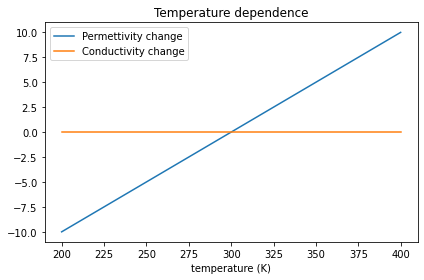

In [7]:
heat_spec_solid.plot(temperature=temp_plot_values)
plt.show()

Define a few mediums with heat specifications. Note that if you would like to set up a boundary condition on interfaces between mediums you must give those medium names to refer to later.

In [8]:
medium_fluid = td.Medium(
    permittivity=1,
    heat_spec=heat_spec_fluid,
    name="med_fluid",
)

medium_solid1 = td.Medium(
    permittivity=5,
    conductivity=0,
    heat_spec=heat_spec_solid,
    name="med_solid1",
)

medium_solid2 = td.Medium(
    permittivity=6,
    conductivity=0,
    heat_spec=heat_spec_solid,
    name="med_solid2",
)

medium_solid3 = td.Medium(
    permittivity=7,
    conductivity=0,
    heat_spec=heat_spec_solid,
    name="med_solid3",
)

Structures are created as usual. The only addition is that similar to mediums, if you would like to set up a boundary condition on a structure's boundary or between structures you must give those participating structures names to refer to later.

In [9]:
sphere1 = td.Structure(
    geometry=td.Box(center=(0,-3,0), size=(5,8,5)),
    medium=medium_solid1,
    name="sphere1",
)

sphere2 = td.Structure(
    geometry=td.Sphere(center=(1,3,1), radius=3.5),
    medium=medium_solid2,
    name="sphere2",
)    

sphere3 = td.Structure(
    geometry=td.Sphere(center=(0,0,-5), radius=1),
    medium=medium_solid2,
    name="sphere3",
)    

sphere4 = td.Structure(
    geometry=td.Sphere(center=(0,1,-3), radius=2.5),
    medium=medium_solid3,
    name="sphere4",
)    

At this point we can create an FDTD simulation an vizualize it

[12:30:11] WARNING: No sources in simulation.                                                     ]8;id=577137;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=617079;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#579\579]8;;\

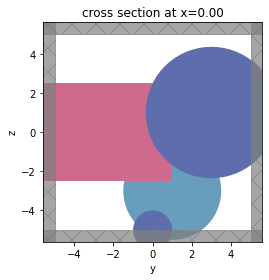

In [10]:
sim = td.Simulation(
    medium=medium_fluid,
    center=[0]*3,
    size=[10]*3,
    grid_spec=td.GridSpec.uniform(dl=0.05),
    structures=[sphere4, sphere1, sphere2, sphere3],
    run_time=1e-20,
)
sim.plot(x=0)
plt.show()

## Boundary conditions

Currently three types of boundary conditions are available: constant temperature (Dirichlet), constant flux (Neumann), and convective (Robin) through classes `HeatBCType = [HeatBCTemperature, HeatBCFlux, HeatBCConvection]`, which are derivatives of abstract `HeatBC`. For example:

In [11]:
bc_temperature = td.HeatBCTemperature(temperature=300)
bc_flux = td.HeatBCFlux(heat_flux=1)
bc_convection = td.HeatBCConvection(ambient_temperature=300, transfer_coeff=1)

Next step is to place these conditions in specific spatial locations. For that we have a number of classes defining different interfaces (derivates of abstract `HeatBCPlacement` and unionized into `HeatBCPlacementType`):
- `HeatBCPlacementStructure`: boundary of a structure.
- `HeatBCPlacementStructureStructure`: interface between two structures.
- `HeatBCPlacementMediumMedium`: interface between two media.
- `HeatBCPlacementSimulation`: boundary of heat simulation domain.
- `HeatBCPlacementStructureSimulation`: part of boundary of heat simulation domain covered by a structure.

When creating thoseExamples:

In [12]:
bc_struct = td.HeatBCPlacementStructure(structure="sphere4", bc=bc_temperature)
bc_struct_sim = td.HeatBCPlacementStructureSimulation(structure="sphere2", bc=bc_flux)
bc_struct_struct = td.HeatBCPlacementStructureStructure(structures=("sphere1", "sphere2"), bc=bc_flux)
bc_sim = td.HeatBCPlacementSimulation(bc=bc_temperature)
bc_med_med = td.HeatBCPlacementMediumMedium(mediums=("med_solid1", "med_fluid"), bc=bc_convection)

## Heat sources

Volumetric heat source can be defined using `HeatUniformSource` and `HeatCustomSource`, for example

In [13]:
heat_src = td.HeatUniformSource(
    geometry=td.Box(center=(0, 0, 0), size=(1, 1, 1)),
    rate=1,
)

`HeatCustomSource` has a similar signature but takes in a spatial array in `rate`.

## Heat simulation

`HeatSimulation` takes in the original FDTD simulation, list of boundary conditions, list of heat sources, and domain in which we would like to solve heat equation. The latter can be left `None` to solve in the entire FDTD simulation domain (excluding PML).

In [14]:
heat_solution_domain = td.Box(center=(0,0,0), size=(8.5,8.5,8.5))

heat_sim = td.HeatSimulation(
    simulation=sim, 
    boundary_conditions=[bc_struct, bc_struct_sim, bc_struct_struct, bc_sim, bc_med_med], 
    sources=[heat_src],
    heat_domain=td.Box(center=(0,0,0), size=(8.5,8.5,8.5)),
)

For now only plotting of boundary conditions is implemented (currently: yellow - temperature bc, green - flux bc, red - convection bc). TODO: plotting of sources and heat properties, shade outside of heat solution domain, color of bc according to temperature/flux values.

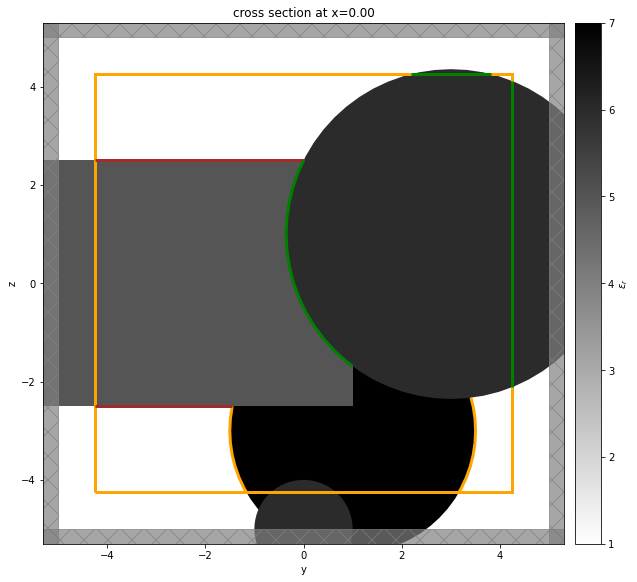

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
heat_sim.simulation.plot_eps(x=0, ax=ax)                       
heat_sim.plot_heat_boundaries(x=0, ax=ax)
plt.show()

## Heat simulation data

Suppose heat solver successfully finished and returned temperature field distribution. Currently, we assume it to be `ScalarFieldTimeDataArray`. But later might need to change to unstructured data.

In [16]:
nx, ny, nz = 92, 36, 54
x = np.linspace(-6, 6, nx)
y = np.linspace(-6, 6, ny)
z = np.linspace(-6, 6, nz)
t = [0]
T = np.random.default_rng().uniform(300, 350, (nx, ny, nz, len(t)))
coords = dict(x=x, y=y, z=z, t=t)
temperature_field = td.ScalarFieldTimeDataArray(T, coords=coords)

After that `HeatSimulationData` object is created that stores this data and associated `HeatSimulation` object.

In [17]:
heat_sim_data = td.HeatSimulationData(
    heat_simulation=heat_sim,
    temperature_data=temperature_field,
)

`HeatSimulationData` can apply temperature distribution to the original FDTD simulation (`HeatSimulationData.heat_simulation.simulation`) and create a new FDTD simulation where all mediums are replaced with corresponding `CustomMedium`.

In [18]:
new_sim = heat_sim_data.apply_heat_to_sim()

[12:30:12] WARNING: No sources in simulation.                                                     ]8;id=811916;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=466185;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#579\579]8;;\

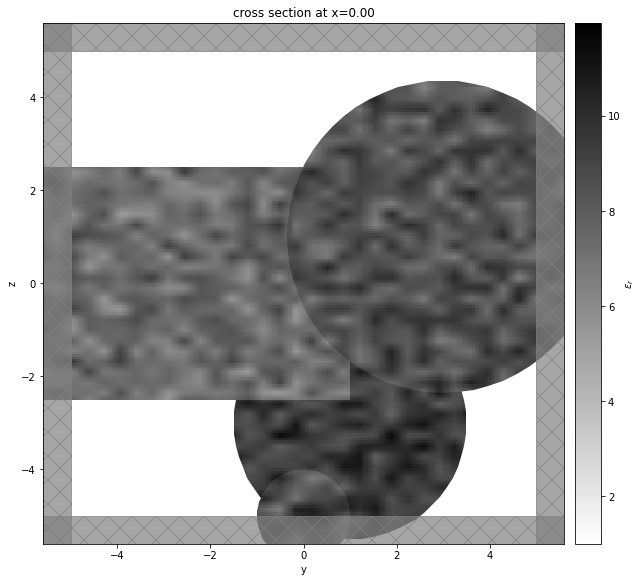

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
new_sim.plot_eps(x=0, ax=ax)
plt.show()